In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from keras.preprocessing import image

In [2]:
class_dict = pd.read_csv('CamVid/class_dict.csv')

path_train = 'CamVid/train/'
path_train_labels = 'CamVid/train_labels/'
path_test = 'CamVid/test/'
path_test_labels = 'CamVid/test_labels/'
path_val = 'CamVid/val/'
path_val_labels = 'CamVid/val_labels/'



train_images_paths = list(Path(path_train).iterdir())

In [3]:
single_image = image.load_img(train_images_paths[0])
image_size = (int(single_image.size[0]/2), single_image.size[1])
image_size

(480, 720)

In [4]:
from keras.preprocessing import image

train_imgs_paths = list(sorted(Path(path_train).iterdir()))
train_masks_paths = list(sorted(Path(path_train_labels).iterdir()))
test_imgs_paths = list(sorted(Path(path_test).iterdir()))
test_masks_paths = list(sorted(Path(path_test_labels).iterdir()))
val_imgs_paths = list(sorted(Path(path_val).iterdir()))
val_masks_paths = list(sorted(Path(path_val_labels).iterdir()))

In [5]:
image_size = (128, 192)

In [6]:
train_images = []
train_masks = []

for i_img, i_mask in zip(train_imgs_paths, train_masks_paths):
    train_images.append(image.load_img(i_img, target_size=image_size))
    train_masks.append(image.load_img(i_mask, target_size=image_size))

In [7]:
test_images = []
test_masks = []

for i_img, i_mask in zip(test_imgs_paths, test_masks_paths):
    test_images.append(image.load_img(i_img, target_size=image_size))
    test_masks.append(image.load_img(i_mask, target_size=image_size))

In [8]:
val_images = []
val_masks = []

for i_img, i_mask in zip(val_imgs_paths, val_masks_paths):
    val_images.append(image.load_img(i_img, target_size=image_size))
    val_masks.append(image.load_img(i_mask, target_size=image_size))

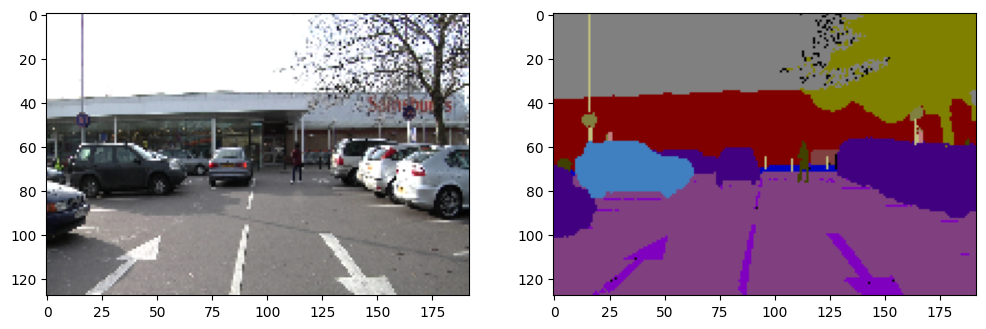

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 12))
ax[0].imshow(train_images[60].convert('RGBA'))
ax[1].imshow(train_masks[60].convert('RGBA'))

In [10]:
X_train = []

for img in train_images:
  x = image.img_to_array(img)
  X_train.append(x)

X_train = np.array(X_train)
print(X_train.shape)

(369, 128, 192, 3)


In [11]:
X_test = []

for img in test_images:
  x = image.img_to_array(img)
  X_test.append(x)

X_test = np.array(X_test)
print(X_test.shape)

(232, 128, 192, 3)


In [12]:
X_val = []

for img in val_images:
  x = image.img_to_array(img)
  X_val.append(x)

X_val = np.array(X_val)
print(X_val.shape)

(100, 128, 192, 3)


In [14]:
arr_col = []

for r, g, b in zip(class_dict['r'], class_dict['g'], class_dict['b']):
  arr_col.append([r, g, b]) 

In [15]:
import cv2


def Color2index(y, arr_col=arr_col):

    y_ind = np.zeros((y.shape[0], y.shape[1]))
    y_cat = np.zeros((y.shape[0], y.shape[1], len(arr_col)))
    i = 1
    for i_color in arr_col:
        ind_i = np.where(
            (y[..., 0] == i_color[0]) 
            & (y[..., 1] == i_color[1])
            & (y[..., 2] == i_color[2])
        )
        y_ind[ind_i[0], ind_i[1]] = i
        y_cat[ind_i[0], ind_i[1], i-1] = 1 
        i += 1
    
    return y_cat, y_ind#, i-1

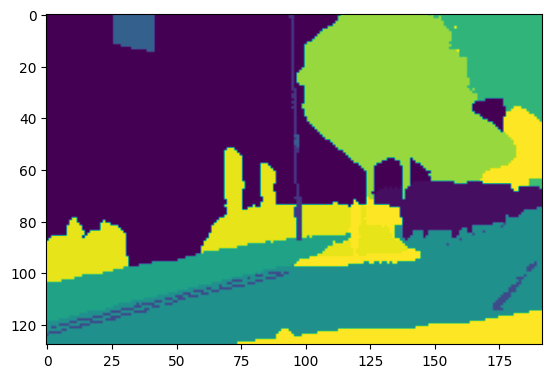

In [16]:
cat_yi, ind_yi = Color2index(image.img_to_array(train_masks[15]))
plt.imshow(ind_yi)
plt.show()  

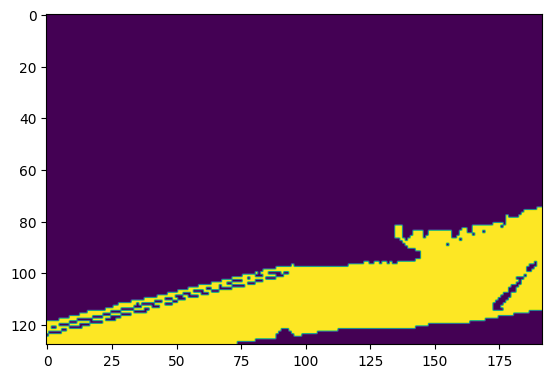

In [18]:
plt.imshow(cat_yi[..., 17])
plt.show()

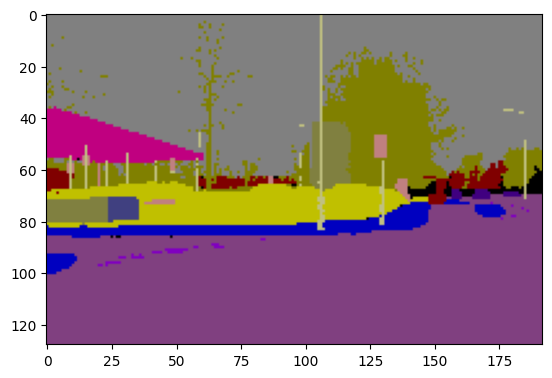

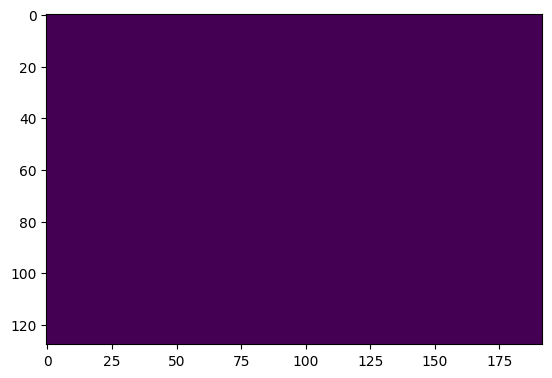

In [21]:
n = 35
plt.imshow(train_masks[n].convert('RGBA'))
plt.show()
img = y_train[n][..., 22]

plt.imshow(img)
plt.show()

In [22]:
y_test = []

for mask in test_masks:
  y_cat, _ = Color2index(image.img_to_array(mask))
  y_test.append(y_cat)

y_test = np.array(y_test)

In [23]:
y_val = []

for mask in val_masks:
  y_cat, _ = Color2index(image.img_to_array(mask))
  y_val.append(y_cat)

y_val = np.array(y_val)


In [25]:
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model, Sequential
from keras.layers import (Activation, Input, MaxPooling2D, BatchNormalization, 
                          Conv2D, Conv2DTranspose, concatenate)
from tensorflow.keras.utils import plot_model


def unet_pre_train(num_classes=32, input_shape=(128, 162, 3)):    
    pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights='imagenet')

    for layer in pre_trained_model.layers[:-5]:
        layer.trainable = False

    x = pre_trained_model.layers[13].output
    block_4_out = pre_trained_model.layers[10].output
    block_3_out = pre_trained_model.layers[6].output
    block_2_out = pre_trained_model.layers[3].output
    img_input = pre_trained_model.inputs
    print(block_4_out)
    print(block_3_out)
    print(block_2_out)
   
    # UP 1

    # добавили перенос из VGG16
    x = concatenate([x, block_4_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из VGG16
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из VGG16
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    return model

In [30]:
model = unet_pre_train(32, (128, 192, 3))

plot_model(model, to_file='model.png', show_shapes=True)

KerasTensor(type_spec=TensorSpec(shape=(None, 16, 24, 256), dtype=tf.float32, name=None), name='block3_pool/MaxPool:0', description="created by layer 'block3_pool'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 48, 128), dtype=tf.float32, name=None), name='block2_pool/MaxPool:0', description="created by layer 'block2_pool'")
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 96, 64), dtype=tf.float32, name=None), name='block1_pool/MaxPool:0', description="created by layer 'block1_pool'")
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [31]:
import keras.backend as K

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred)) / (K.sum(y_true) + K.sum(y_pred))

In [32]:
from tensorflow.keras.optimizers import Adam


model.compile(optimizer=Adam(),
                loss='categorical_crossentropy',
                metrics=[dice_coef])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 192, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 128, 192, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 128, 192, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 64, 96, 64)           0         ['block1_conv2[0][0]']        
                                                                                              

                                                                                                  
 conv2d_8 (Conv2D)           (None, 128, 192, 32)         18464     ['activation_10[0][0]']       
                                                                                                  
Total params: 12365216 (47.17 MB)
Trainable params: 4726240 (18.03 MB)
Non-trainable params: 7638976 (29.14 MB)
__________________________________________________________________________________________________


In [33]:
sample_image = X_test[5]
sample_mask = y_test[5]

In [34]:
import keras
from IPython.display import clear_output


def show_predictions(model):
    pred_mask = model.predict(sample_image[None])[..., 16]
    print(pred_mask.shape)

    fig, ax = plt.subplots(1, 3, figsize=(15, 8))

    ax[0].imshow(sample_image / 255.0)
    ax[1].imshow(sample_mask[..., 16])
    ax[2].imshow(np.squeeze(pred_mask, axis=0))
    plt.show()


class DisplayCallback(keras.callbacks.Callback):
    def __init__(self, patience=1):
        super().__init__()
        self.patience = patience
    
    def on_train_begin(self, logs=None):
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        self.wait += 1
        if self.wait >= self.patience:
            clear_output(wait=True)
            show_predictions(self.model)
            print(f'\nSample Prediction after epoch {epoch+1}')
            self.wait = 0

1/1 [==============================] - 5s 5s/step
(1, 128, 192)


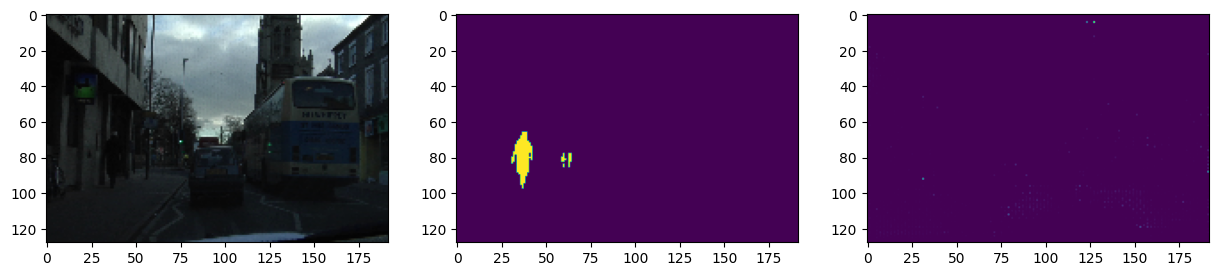

In [35]:
show_predictions(model)

In [36]:
history = model.fit(preprocess_input(X_train), y_train,
                      epochs=5,
                      batch_size=10,
                      validation_data=(preprocess_input(X_test), y_test),
                      callbacks=[DisplayCallback(patience=5)])

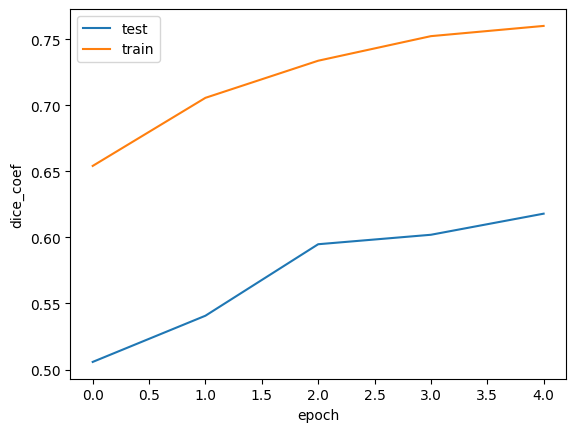

In [39]:
plt.plot(history.history['val_dice_coef'], label='test')
plt.plot(history.history['dice_coef'], label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

In [40]:
pred = model.predict(X_val)
print(pred.shape)

4/4 [==============================] - 167s 40s/step
(100, 128, 192, 32)


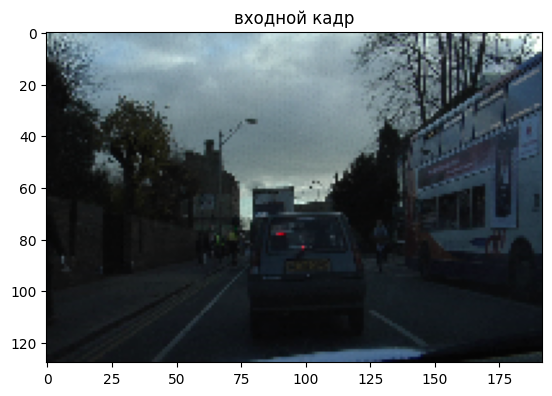

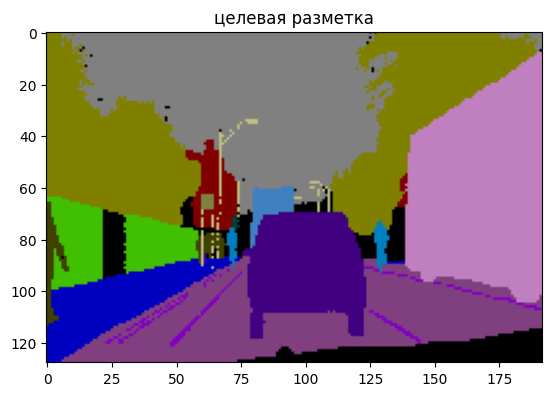

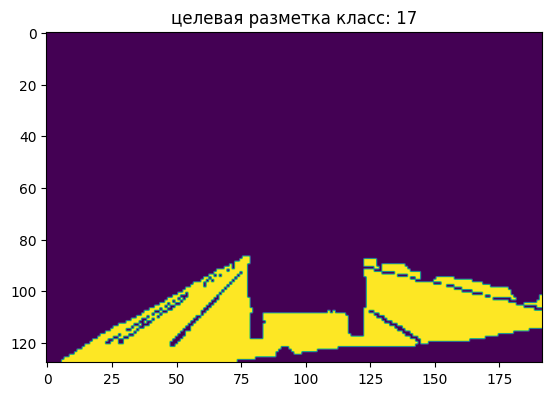

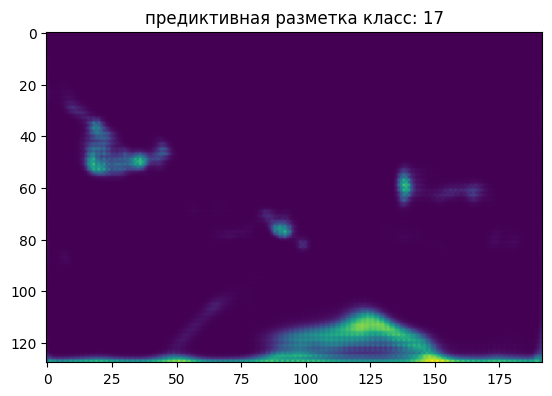

In [41]:
n = 1
class_ = 17
plt.imshow(val_images[n].convert('RGBA'))
plt.title('входной кадр')
plt.show()
plt.imshow(val_masks[n].convert('RGBA'))
plt.title('целевая разметка')
plt.show()
img = y_val[n][..., class_]
plt.imshow(img)
plt.title('целевая разметка класс: ' + str(class_))
plt.show()
img = pred[n][..., class_]
plt.imshow(img)
plt.title('предиктивная разметка класс: ' + str(class_))
plt.show()